## HW2 Problem 4
## Name: Liam Jackson

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score


### 1. Logistic regression

#### a.

In [2]:
raw_data_df = pd.read_csv('data.csv')

radius_mean = raw_data_df['radius_mean'].to_numpy().reshape(-1,1)
diag_str = raw_data_df['diagnosis'].to_numpy()
diag = diag_str.copy()

for ind, diag_el in enumerate(diag_str):
    if str(diag_el) == 'M':
        diag[ind] = 1
    elif str(diag_el) == 'B':
        diag[ind] = 0

#### b.

In [3]:
log_reg = LogisticRegression()
log_reg.fit(radius_mean, diag_str)

rad_min = round(np.min(radius_mean))
rad_max = round(np.max(radius_mean))
rad_step = (rad_max - rad_min) * 100 
rad_new = np.linspace(rad_min, rad_max, rad_step).reshape(-1,1)

diag_pred_prob = log_reg.predict_proba(rad_new)

fifty_ind = np.where((diag_pred_prob[:,0] >= .495) & (diag_pred_prob[:,0] <= .505))
dec_bnd = np.mean(rad_new[fifty_ind,0])

print(f"The decision boundary is {dec_bnd} um")

The decision boundary is 14.75869461648404 um


#### c. 

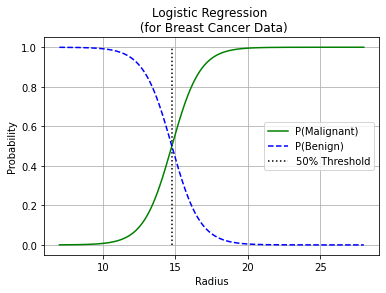

In [4]:
plt.plot(rad_new, diag_pred_prob[:,1], "g-", label= "P(Malignant)")
plt.plot(rad_new, diag_pred_prob[:,0], "b--", label= "P(Benign)")
plt.vlines(dec_bnd, 0, 1, colors = 'k', linestyles = 'dotted', label = '50% Threshold')
# plt.scatter(radius_mean, diag, label = 'Biopsies')
plt.title('Logistic Regression \n (for Breast Cancer Data)')
plt.xlabel('Radius')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.show()

### 2. Cost function plot
#### a.

In [5]:
w0_fitted = log_reg.intercept_
w1_fitted = log_reg.coef_[0]

w0_bnd = 10
w1_bnd = 5

w0_range = np.linspace(w0_fitted-w0_bnd, w0_fitted+w0_bnd, 100).squeeze()
w1_range = np.linspace(w1_fitted-w1_bnd, w1_fitted+w1_bnd, 100).squeeze()

W0, W1 = np.meshgrid(w0_range, w1_range)

N = radius_mean.shape[0]
J = np.zeros(W0.shape)

def sigmoid(x, w0_internal, w1_internal):
    S = np.zeros(len(x))
    for i in range(0,len(x)):
        S_temp = 1/(1+np.exp(-(w0_internal + w1_internal*x[i])))
        if S_temp == 0:
            S_temp = 0.000001
        elif S_temp == 1:
            S_temp = .999999
        S[i] = S_temp
    return S

for w0_ind, w0 in enumerate(w0_range):
    for w1_ind, w1 in enumerate(w1_range):
        
        fx = sigmoid(radius_mean, w0, w1)
        
        J_temp = 0
        for i in range(N):
            yi = diag[i]
            fxi = fx[i]
            J_temp += (yi*np.log(fxi) + (1 - yi)*np.log(1-fxi))
            
        J[w1_ind, w0_ind] = (-1/N)*J_temp

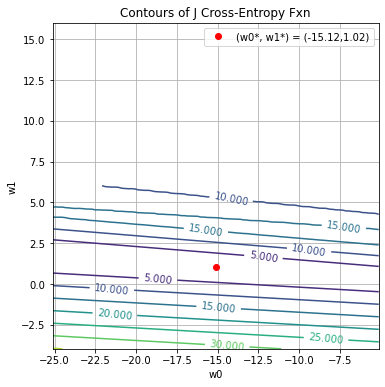

In [6]:
plt.figure(figsize = (6,6))

CS = plt.contour(W0,W1,J) #, 20, colors = 'k')
plt.clabel(CS, inline = True, fontsize = 10)
plt.plot(w0_fitted, w1_fitted, 'ro',
         label = f'(w0*, w1*) = ({"{:.2f}".format(w0_fitted[0])},{"{:.2f}".format(w1_fitted[0])})')
plt.title('Contours of J Cross-Entropy Fxn')
plt.axis('square')
plt.xlabel('w0')
plt.ylabel('w1')
plt.legend()
plt.grid()
plt.show()

#### b.

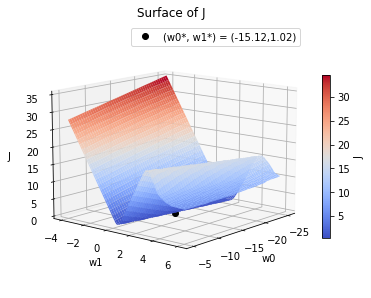

In [7]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(W0, W1, J, cmap = cm.coolwarm, linewidth = 20)
point = ax.plot(w0_fitted, w1_fitted, 'ko', 
                label = f'(w0*, w1*) = ({"{:.2f}".format(w0_fitted[0])},{"{:.2f}".format(w1_fitted[0])})')
fig.colorbar(surf, shrink = 0.5, label = 'J')

ax.set_title('Surface of J')
ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('J')
plt.legend()

ax.view_init(12, 40)
plt.show()

### 3. ROC
#### a.

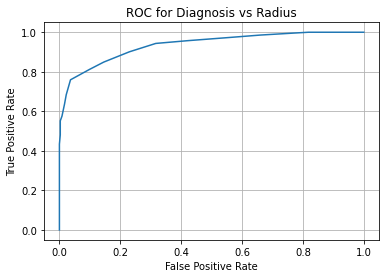

In [34]:
thresh_range = np.arange(5,30.5,.5)

roc = np.zeros([len(thresh_range), 3])
roc[:,0] = thresh_range

for thresh_ind, thresh in enumerate(thresh_range):
    tp_roc = 0
    fp_roc = 0
    tn_roc = 0
    fn_roc = 0    
    for instance, radius in enumerate(radius_mean):
        if radius >= thresh and diag[instance] == 1:
            tp_roc += 1 
        elif radius >= thresh and diag[instance] == 0:
            fp_roc += 1 
        elif radius <= thresh and diag[instance] == 0:
            tn_roc += 1 
        elif radius <= thresh and diag[instance] == 1:
            fn_roc += 1 
            
    tp_fn = tp_roc + fn_roc
    tn_fp = tn_roc + fp_roc
    
    specificity = tn_roc / (tn_fp)
    fpr = 1 - specificity
    tpr = tp_roc / tp_fn
    roc[thresh_ind, 1:] = [fpr, tpr]

plt.plot(roc[:,1],roc[:,2])
plt.title('ROC for Diagnosis vs Radius')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()
        

#### b.

In [24]:
# dint64 = diag.astype('int64')
# dpint64 = log_reg.predict_proba(radius_mean)[:,1].astype('int64')
# auc = roc_auc_score(dint64, dpint64)

zero = np.array([0])
fpr = roc[:,1]
tpr = roc[:,2]
tpr_diff = np.hstack((np.diff(tpr), zero))
fpr_diff = np.hstack((np.diff(fpr), zero))
auc = abs(np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2)

print(f'The AUC for the above ROC curve is: {auc}')

The AUC for the above ROC curve is: 0.9352174832197029


#### c.

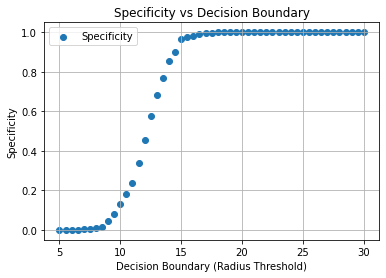

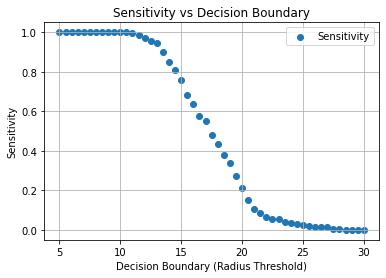

In [27]:
plt.scatter(roc[:,0],1-roc[:,1], label = 'Specificity')
plt.title('Specificity vs Decision Boundary')
plt.xlabel('Decision Boundary (Radius Threshold)')
plt.ylabel('Specificity')
plt.grid()
plt.legend()
plt.show()

plt.scatter(roc[:,0],roc[:,2], label = 'Sensitivity')
plt.title('Sensitivity vs Decision Boundary')
plt.xlabel('Decision Boundary (Radius Threshold)')
plt.ylabel('Sensitivity')
plt.grid()
plt.legend()
plt.show()

### 4. Confusion matrix
#### a.

tp = 167 
fp = 24 
tn = 333 
fn = 45


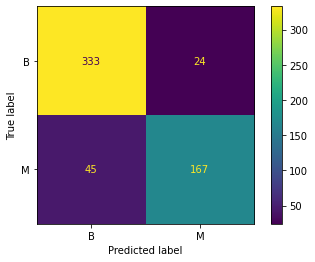

In [28]:
diag_pred = log_reg.predict(radius_mean)
diag_real = diag_str

conf_mtx = confusion_matrix(diag_real, diag_pred)
# "the count of true negatives is 0,0, false negatives is 1,0, 
# true positives is 1,1 and false positives is 0,1" 
tp = conf_mtx[1,1]
fp = conf_mtx[0,1]
tn = conf_mtx[0,0]
fn = conf_mtx[1,0]
print(f'tp = {tp} \nfp = {fp} \ntn = {tn} \nfn = {fn}')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=log_reg.classes_)

disp.plot()

#### b.

In [29]:
print(f'The sensitivity for the optimized model is: {tp/(tp+fn)}')
print(f'The specificity for the optimized model is: {tn/(tn+fp)}')

The sensitivity for the optimized model is: 0.7877358490566038
The specificity for the optimized model is: 0.9327731092436975
